**Import Libraries**

In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model

ModuleNotFoundError: No module named 'pandas'

## Import data form Google Drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATADIR = "/content/drive/MyDrive/CK+48"

In [ ]:
CATEGORIES = os.listdir(DATADIR)  # list of directory
CATEGORIES

['sadness', 'contempt', 'disgust', 'surprise', 'happy', 'fear', 'anger']

In [ ]:
def load_data():
    DATADIR ="/content/drive/MyDrive/CK+48"
    data = []
    # loading training data
    for category in CATEGORIES:
        # create path to image of respective expression
        path = os.path.join(DATADIR, category)
        # get the classification  for each expression 
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img), 0)
            data.append([img_array, class_num])
            
    return data

In [ ]:
data = load_data()
len(data)

100%|██████████| 135/135 [00:01<00:00, 118.47it/s]


981

## Lets Visualize some images

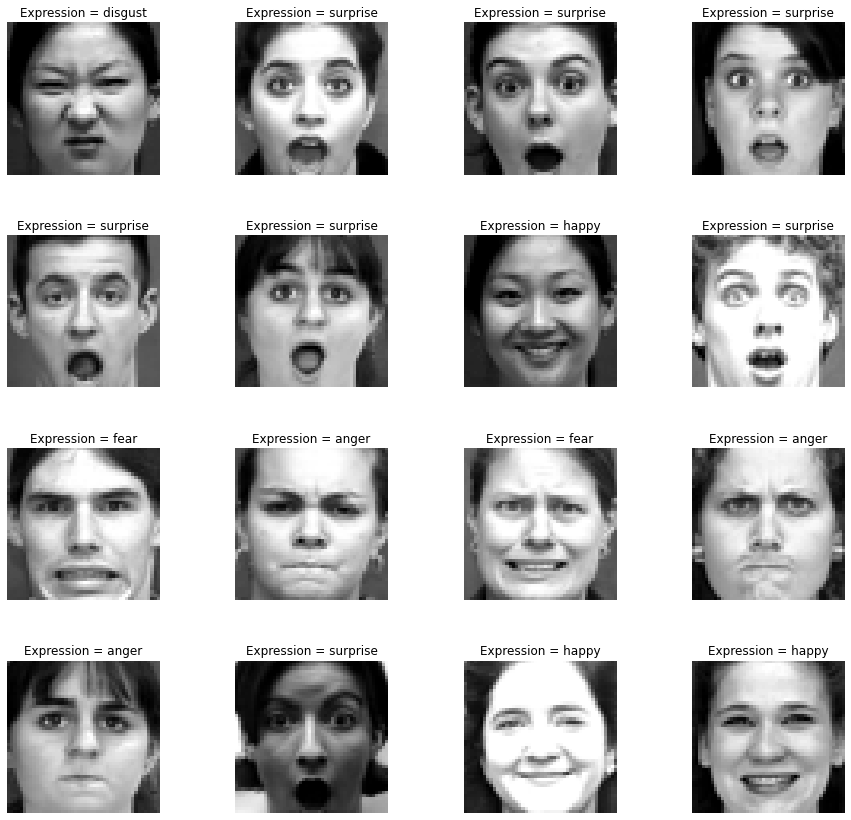

In [ ]:
L = 4
W = 4
fig, axes = plt.subplots(L, W, figsize = (15,15))
axes = axes.ravel()

for i in range(0, L * W):  
    sample = random.choice(data)
    axes[i].set_title("Expression = "+str(CATEGORIES[sample[1]]))
    axes[i].imshow(sample[0], cmap='gray')
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

## Creating training and testing data

In [ ]:
X = np.array([x[0] for x in data])
y = np.array([Y[1] for Y in data])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

In [ ]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("-------------------------------")
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (784, 48, 48)
y_train shape:  (784,)
-------------------------------
X_test shape:  (197, 48, 48)
y_test shape:  (197,)


In [ ]:
# reshaping y_train and y_test
y_train = np.reshape(y_train, (len(y_train),1))
y_test  = np.reshape(y_test , (len(y_test ),1))

print("After reshaping")
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

After reshaping
y_train shape:  (784, 1)
y_test shape:  (197, 1)


In [ ]:
X_train_Gabor  = X_train
X_test_Gabor = X_test

In [ ]:
print(X_train.shape)
print(X_test.shape)

(784, 48, 48)
(197, 48, 48)


## Adding colour channel

In [ ]:
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

print("After adding color channel")
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

After adding color channel
X_train shape:  (784, 48, 48, 1)
X_test shape:  (197, 48, 48, 1)


## Normalizing pixel values

In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0

## Converting single values to category array

In [ ]:
y_train[0]

array([6])

In [ ]:
y_train_SVM = y_train
y_test_SVM = y_test

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [ ]:
y_train.shape, y_test.shape

((784, 7), (197, 7))

## **Creat CNN Model**

In [ ]:
def create_model(input_shape=None):
    if input_shape is None :
        input_shape=(48,48,1)

    model = Sequential()
    model.add(Conv2D(7, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    
    model.add(Dense(128, activation = 'relu'))
    
    
    model.add(Dense(7, activation = 'softmax'))
    
    return model 

In [ ]:
es = EarlyStopping(
    monitor='val_accuracy', min_delta=0.0001, patience=10, verbose=2,
    mode='max', baseline=None, restore_best_weights=True
)
lr = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=2,
    mode='max', min_delta=1e-5, cooldown=0, min_lr=0
)

callbacks = [es, lr]

In [ ]:
Model = create_model()
Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 7)         182       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 7)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        2816      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 12, 12, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        9

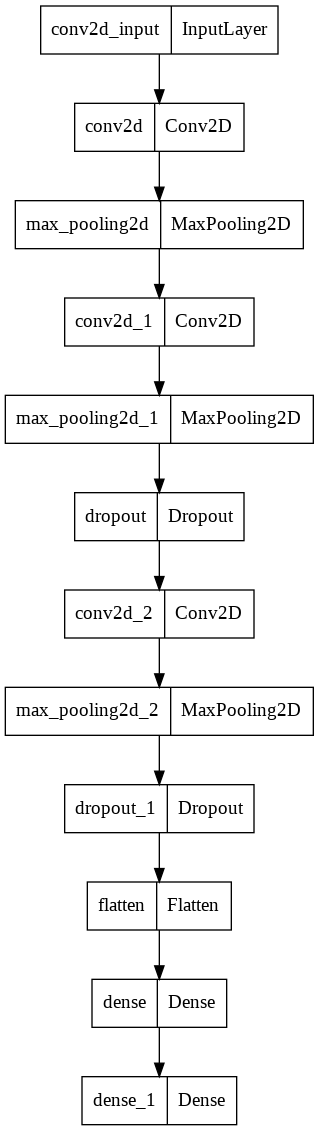

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(Model, to_file='model.png')

## **Training Model**

In [ ]:
WFE_model = create_model()
WFE_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam' )

In [ ]:
WFE_history = WFE_model.fit(X_train, y_train, batch_size=8 , epochs=20, validation_data = (X_test, y_test) ,callbacks = [callbacks])

Epoch 1/20
98/98 [==============================] - 4s 34ms/step - loss: 1.8336 - accuracy: 0.2691 - val_loss: 1.7088 - val_accuracy: 0.4822 - lr: 0.0010
Epoch 2/20
98/98 [==============================] - 3s 32ms/step - loss: 1.3658 - accuracy: 0.5230 - val_loss: 0.8904 - val_accuracy: 0.6599 - lr: 0.0010
Epoch 3/20
98/98 [==============================] - 3s 32ms/step - loss: 0.9325 - accuracy: 0.6454 - val_loss: 0.7687 - val_accuracy: 0.7056 - lr: 0.0010
Epoch 4/20
98/98 [==============================] - 3s 32ms/step - loss: 0.7378 - accuracy: 0.7219 - val_loss: 0.5086 - val_accuracy: 0.8020 - lr: 0.0010
Epoch 5/20
98/98 [==============================] - 3s 32ms/step - loss: 0.5729 - accuracy: 0.7946 - val_loss: 0.3819 - val_accuracy: 0.8680 - lr: 0.0010
Epoch 6/20
98/98 [==============================] - 3s 32ms/step - loss: 0.4978 - accuracy: 0.8253 - val_loss: 0.3504 - val_accuracy: 0.8883 - lr: 0.0010
Epoch 7/20
98/98 [==============================] - 3s 32ms/step - loss: 0.4

In [ ]:
def plot_performance(history):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val loss evolution')

    plt.subplot(2, 1, 2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val accuracy')

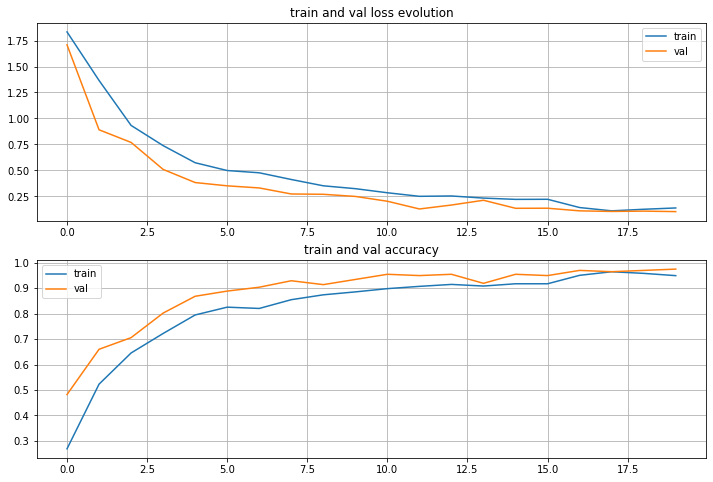

In [ ]:
plot_performance(WFE_history)

In [ ]:
acc = []

In [ ]:
WFE_acc = WFE_model.evaluate(X_test, y_test, verbose = 0)[1]
acc.append(WFE_acc)
print("Without Feature extraction Accuracy :", WFE_acc)

Without Feature extraction Accuracy : 0.9746192693710327


In [ ]:
predict_x=WFE_model.predict(X_test)

7/7 [==============================] - 0s 26ms/step


In [ ]:
rounded_X_test=np.argmax(predict_x, axis=1)
rounded_X_test[1]

3

In [ ]:
rounded_y_test=np.argmax(y_test, axis=1)
rounded_y_test[1]

3

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(rounded_y_test,rounded_X_test)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        17
           1       0.73      1.00      0.84         8
           2       1.00      1.00      1.00        36
           3       1.00      0.98      0.99        54
           4       1.00      1.00      1.00        44
           5       0.92      0.80      0.86        15
           6       0.96      1.00      0.98        23

    accuracy                           0.97       197
   macro avg       0.94      0.96      0.95       197
weighted avg       0.98      0.97      0.98       197



In [ ]:
WFE_model.save('WFE_model_2.h5')

# Training Model Using LBP Feature Extraction Technique

In [ ]:
def Binarypattern(im):                               # creating function to get local binary pattern
    img= np.zeros_like(im)
    n=3  
    print(im.shape[0])# taking kernel of size 3*3
    for i in range(0,im.shape[0]-n):                 # for image height
        for j in range(0,im.shape[1]-n):               # for image width
            x  = im[i:i+n,j:j+n]                     # reading the entire image in 3*3 format
            center       = x[1,1]                    # taking the center value for 3*3 kernel
            img1        = (x >= center)*1.0          # checking if neighbouring values of center value is greater or less than center value
            img1_vector = img1.T.flatten()           # getting the image pixel values 
            img1_vector = np.delete(img1_vector,4)  
            digit = np.where(img1_vector)[0]         
            if len(digit) >= 1:                     # converting the neighbouring pixels according to center pixel value
                num = np.sum(2**digit)              # if n> center assign 1 and if n<center assign 0
            else:                                    # if 1 then multiply by 2^digit and if 0 then making value 0 and aggregating all the values
                                                    #of kernel to get new center value
                num = 0
            img[i+1,j+1] = num
    return(img)

In [ ]:
X_train.shape

(784, 48, 48, 1)

In [ ]:
def create_LBP_features(data):
    Feature_data = np.zeros(data.shape)

    for i in range(len(data)):
        img = data[i]
        imgLBP=Binarypattern(img)  
        Feature_data[i] = imgLBP
    
    return Feature_data

In [ ]:
Feature_X_train = create_LBP_features(X_train)

48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
4

In [ ]:
Feature_X_train.shape

(784, 48, 48, 1)

In [ ]:
Feature_X_test = create_LBP_features(X_test)


48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48


In [ ]:
# Training And Testing LBP-CNN model

In [ ]:
LBP_model = create_model()
LBP_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam' )


'''def create_model(input_shape=None):
    if input_shape is None :
        input_shape=(48,48,1)

    model_LBP = Sequential()

    model_LBP.add(Flatten())
    
    model_LBP.add(Dense(128, activation = 'relu'))
    
    
    model_LBP.add(Dense(7, activation = 'softmax'))
    
    return model_LBP 

    LBP_model = create_model_LBP()
    LBP_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam' )'''

"def create_model(input_shape=None):\n    if input_shape is None :\n        input_shape=(48,48,1)\n\n    model_LBP = Sequential()\n\n    model_LBP.add(Flatten())\n    \n    model_LBP.add(Dense(128, activation = 'relu'))\n    \n    \n    model_LBP.add(Dense(7, activation = 'softmax'))\n    \n    return model_LBP \n\n    LBP_model = create_model_LBP()\n    LBP_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam' )"

In [ ]:
LBP_history = LBP_model.fit(Feature_X_train, y_train, batch_size=8 , epochs=20, validation_data = (Feature_X_test, y_test) ,callbacks = [callbacks])

Epoch 1/20
98/98 [==============================] - 4s 35ms/step - loss: 12.1278 - accuracy: 0.1760 - val_loss: 1.8143 - val_accuracy: 0.2640 - lr: 0.0010
Epoch 2/20
98/98 [==============================] - 3s 33ms/step - loss: 1.9133 - accuracy: 0.2513 - val_loss: 1.7427 - val_accuracy: 0.3299 - lr: 0.0010
Epoch 3/20
98/98 [==============================] - 3s 34ms/step - loss: 1.7787 - accuracy: 0.3176 - val_loss: 1.7483 - val_accuracy: 0.3249 - lr: 0.0010
Epoch 4/20
98/98 [==============================] - 3s 34ms/step - loss: 1.7098 - accuracy: 0.3571 - val_loss: 1.6464 - val_accuracy: 0.4670 - lr: 0.0010
Epoch 5/20
98/98 [==============================] - 3s 34ms/step - loss: 1.6368 - accuracy: 0.3737 - val_loss: 1.6108 - val_accuracy: 0.4213 - lr: 0.0010
Epoch 6/20
98/98 [==============================] - 3s 34ms/step - loss: 1.4386 - accuracy: 0.4630 - val_loss: 1.3408 - val_accuracy: 0.5533 - lr: 0.0010
Epoch 7/20
98/98 [==============================] - 3s 34ms/step - loss: 1.

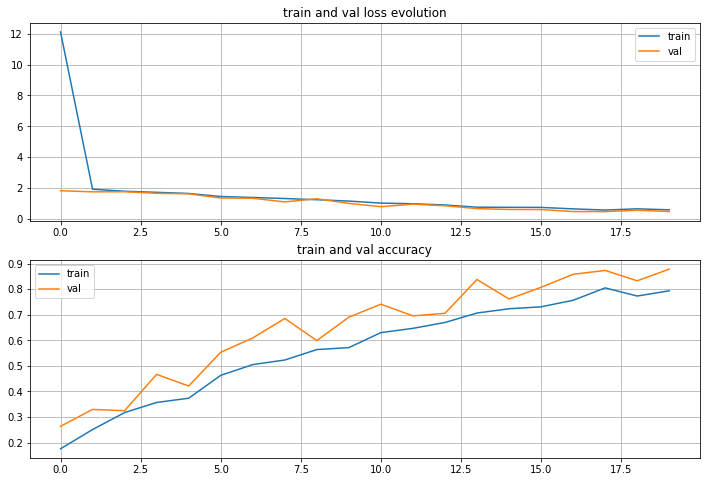

In [ ]:
plot_performance(LBP_history)

In [ ]:
LBP_acc = LBP_model.evaluate(Feature_X_test, y_test, verbose = 0)[1]
acc.append(LBP_acc)
print("LBP Accuracy :",LBP_model.evaluate(Feature_X_test, y_test, verbose = 0)[1])

LBP Accuracy : 0.8781725764274597


In [ ]:
LBP_model.save('LBP_model.h5')

# Training Model Using HOG Feature Extraction Technique

In [ ]:
from skimage.transform import resize
from skimage.feature import hog

## How HOG looks

## Creating Feature Vectors For training and testing

In [ ]:
def Create_Hog_features(data):
    Feature_data = np.zeros((len(data),48,48))

    for i in range(len(data)):
        img = data[i]
        resized_img = resize(img, (128, 64))
        fd, hog_image = hog(
            resized_img, 
            orientations=9, 
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2), 
            visualize=True, 
            multichannel=True
        )
        Feature_data[i] = resize(hog_image, (48, 48))
    return Feature_data

In [ ]:
Feature_X_train = Create_Hog_features(X_train)
Feature_X_train.shape

(784, 48, 48)

(-0.5, 47.5, 47.5, -0.5)

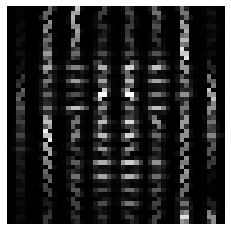

In [ ]:
plt.imshow(random.choice(Feature_X_train), cmap='gray')
plt.axis('off')

In [ ]:
# doing same for test data 
Feature_X_test = Create_Hog_features(X_test)

Feature_X_test.shape

(197, 48, 48)

(-0.5, 47.5, 47.5, -0.5)

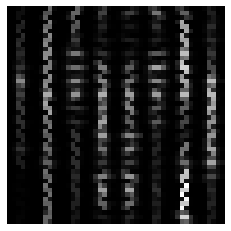

In [ ]:
plt.imshow(random.choice(Feature_X_test), cmap='gray')
plt.axis('off')

In [ ]:
# Again adding color channel as it got removed while converting img to hog img
X_train_HOG = np.expand_dims(Feature_X_train, axis=3)
X_test_HOG = np.expand_dims(Feature_X_test, axis=3)

print("After adding color channel")
print("X_train_HOG shape: ", X_train_HOG.shape)
print("X_test_HOG shape: ", X_test_HOG.shape)

After adding color channel
X_train_HOG shape:  (784, 48, 48, 1)
X_test_HOG shape:  (197, 48, 48, 1)


In [ ]:
print("X_train_HOG shape: ", X_train_HOG.shape)
print("y_train shape: ", y_train.shape)
print("X_test_HOG shape: ", X_test_HOG.shape)
print("y_test shape: ", y_test.shape)

X_train_HOG shape:  (784, 48, 48, 1)
y_train shape:  (784, 7)
X_test_HOG shape:  (197, 48, 48, 1)
y_test shape:  (197, 7)


## Training and Testing the Hog - CNN model

In [ ]:
HOG_model = create_model()

In [ ]:
HOG_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 48, 48, 7)         182       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 24, 24, 7)        0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 24, 24, 16)        2816      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 12, 12, 16)       0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 12, 12, 16)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 10, 10, 64)       

In [ ]:
HOG_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam' )

In [ ]:
HOG_history = HOG_model.fit(X_train_HOG, y_train, batch_size=8 , epochs=100, validation_data = (X_test_HOG, y_test), callbacks = [callbacks])

Epoch 1/100
98/98 [==============================] - 4s 44ms/step - loss: 0.1201 - accuracy: 0.9630 - val_loss: 0.2521 - val_accuracy: 0.9543 - lr: 1.0000e-08
Epoch 2/100
98/98 [==============================] - 3s 34ms/step - loss: 0.1276 - accuracy: 0.9528 - val_loss: 0.2521 - val_accuracy: 0.9543 - lr: 1.0000e-08
Epoch 3/100
98/98 [==============================] - 3s 34ms/step - loss: 0.1607 - accuracy: 0.9375 - val_loss: 0.2521 - val_accuracy: 0.9543 - lr: 1.0000e-08
Epoch 4/100
98/98 [==============================] - 3s 33ms/step - loss: 0.1324 - accuracy: 0.9617 - val_loss: 0.2521 - val_accuracy: 0.9543 - lr: 1.0000e-08
Epoch 5/100
98/98 [==============================] - 3s 34ms/step - loss: 0.1258 - accuracy: 0.9643 - val_loss: 0.2521 - val_accuracy: 0.9543 - lr: 1.0000e-08
Epoch 6/100
97/98 [============================>.] - ETA: 0s - loss: 0.1170 - accuracy: 0.9601
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
98/98 [===========================

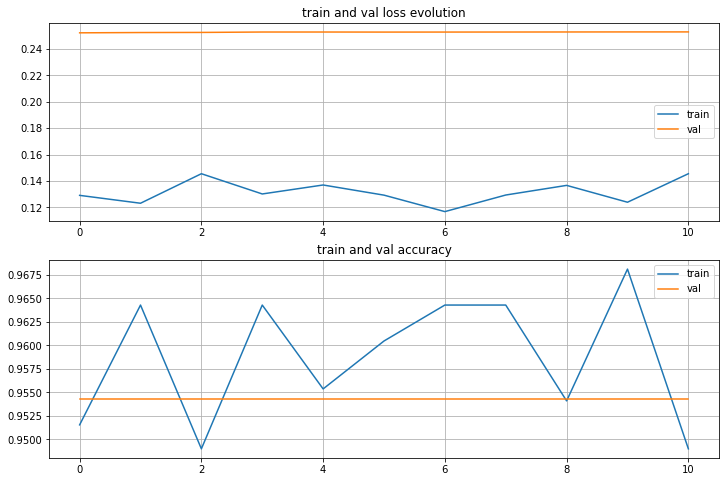

In [ ]:
plot_performance(HOG_history)

In [ ]:
HOG_acc = HOG_model.evaluate(X_test_HOG, y_test, verbose = 0)[1]
acc.append(HOG_acc)
print("HOG Accuracy :",HOG_model.evaluate(X_test_HOG, y_test, verbose = 0)[1])

HOG Accuracy : 0.9543147087097168


In [ ]:
HOG_model.save('HOG_model.h5')